# Setup Paths - Define as pastas e variáveis

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'  
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# Copy Model Config to Training Folde

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

# Update Config For Transfer Learning

In [3]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [5]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [6]:
config

{'model': ssd {
   num_classes: 5
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
    

In [7]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [8]:
pipeline_config.model.ssd.num_classes = 5
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [9]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

# Load Train Model From Checkpoint

In [10]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [11]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect in Real-Time

In [12]:
import cv2 
import numpy as np
import os

In [13]:
past = os.getcwd()+"/imgs"
print(os.listdir(past))
list = os.listdir(past)
idImagem = int (len(list)/2)
idImagem = idImagem+1
idImagem = str(idImagem)

['caixas1.jpg', 'caixas2.jpg', 'caixas3.jpg', 'normal1.jpg', 'normal2.jpg', 'normal3.jpg']


In [14]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [15]:
category_index

{1: {'id': 1, 'name': 'lemon'}, 2: {'id': 2, 'name': 'peduncle'}}

In [16]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


while (cap.isOpened()):
    
    
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    if(ret == True):
        
        #Converte os valorés do array np para float
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        #Carregue o modelo salvo e crie a função de detecção
        detections = detect_fn(input_tensor)

        #Agarra o número de detecções
        num_detections = int(detections.pop('num_detections'))
        #Realiza o pre-processamento dos dados np
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections
        # Converter para inteiros
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=50,
                    min_score_thresh=.55,
                    skip_scores= True,
                    skip_labels= True,
                    agnostic_mode=False)

        imgFundoGray = cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2GRAY)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        imgSemFundo = cv2.subtract(imgFundoGray, frame)

        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
      


        elementoEstruturante = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) 

        dilatacao = cv2.dilate(imgSemFundo, elementoEstruturante, iterations = 1) 
        _, bw = cv2.threshold(dilatacao, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        elementoEstruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
        resul_final = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, elementoEstruturante)

        contours, hierarchy = cv2.findContours(resul_final.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        cv2.imshow("Imagem", cv2.resize(resul_final, (800, 600)))
        
        if cv2.waitKey(1) & 0xFF == ord("s"):            
            # save image
            showPic = cv2.imwrite("imgs/caixas"+idImagem+".jpg",resul_final)
            showPic1 = cv2.imwrite("imgs/normal"+idImagem+".jpg",image_np_with_detections)    
            break

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
            
        
             

cap.release()
cv2.destroyAllWindows()

# 2 - Parte do Código

In [17]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

## Variaveis e caminhos

In [18]:
IMAGEM_CAPTURADA_SEGMENTADA = "imgs/caixas"            + idImagem + ".jpg"
IMAGEM_CAPTURADA_NORMAL =     "imgs/normal"            + idImagem + ".jpg"
IMAGEM_CORTADA_PEDUNCULO =    "cortes/pedunculoCortado"  + idImagem + ".png"
PEDUNCULO_HSV =               "cortes/pedunculoHSV"      + idImagem + ".png"
PEDUNCULO_BGR =               "cortes/pedunculoBGR"      + idImagem + ".png"

### Mostra imagem

In [19]:
def mostraImagem(imagemUso, titulo):

    fig = plt.figure(figsize = (5, 8))
    plt.title(titulo)
    plt.imshow(imagemUso)
    plt.show()

# Imagem Pré-Processada
Encontra a região de corte - trabalha apenas com a fruta

In [20]:
imgPreProcessada = cv.imread(IMAGEM_CAPTURADA_SEGMENTADA) #Leitura da imagem de entrada, imagem deve ser pré-processada - Real Time Object Detection
gray = cv.cvtColor(imgPreProcessada, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

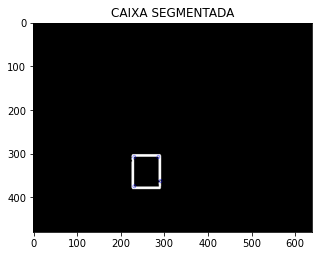

In [21]:
todas_coordenadas = [] #Guarda as coordenadas do eixo X e Y vindas dos cantos encontrados

cornersPedunculo = cv.goodFeaturesToTrack(gray, 4, 0.6, 0.2) #Função responsavel por encontrar os cantos Harrys

for item in cornersPedunculo:
    
    x,y = item[0]
    
    todas_coordenadas.append([x,y])
    cv.circle(imgPreProcessada, (int(x),int(y)), 4, (0,0,255))
    
mostraImagem(imgPreProcessada, "CAIXA SEGMENTADA")

In [22]:
todas_coordenadas.sort() #Ordena as coordenadas em ordem crescente


#Ultiza-se apenas a primeira coordenada e a ultima
xt = todas_coordenadas[0][0]
yt = todas_coordenadas[0][1]

xb = todas_coordenadas[3][0]
yb = todas_coordenadas[3][1]

#print(xt, yt)
#print(xb, yb)

In [23]:
#Regiao de interesse

Lmax = abs(xt - xb)
Hmax = abs(yt - yb)

RoiL = 0.5 * Lmax
RoiH = 0.5 * Hmax

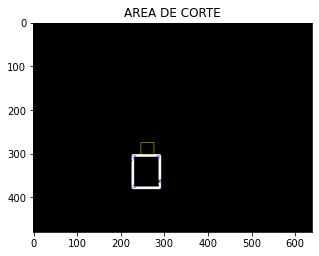

In [24]:
#Area de corte da imagem

#Esses coordenadas são as que vão delimitar a area onde a imagem vai ser cortada

centro = (xb + xt) / 2

centroCaixa = RoiL / 2

x1 = centro - centroCaixa
x2 = centro + centroCaixa

y1 = abs(yt - 5)
y2 = abs(RoiH - y1)

x1 = int(x1)
y1 = int(y1)
x2 = int(x2)
y2 = int(y2)

TopLeftY = y2
TopLeftX = x1

cv.rectangle(imgPreProcessada, (x2, y2), (x1,y1), (255,255,0), 1)

mostraImagem(imgPreProcessada, "AREA DE CORTE")

# Imagem Sem Processamento
Corte

In [25]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL) #Leitura da imagem de entrada, imagem deve ser sem processamento - Real Time Object Detection

In [26]:
crop = img[y2:y1, x1:x2] #Realiza o corte da imagem
cv.imwrite(IMAGEM_CORTADA_PEDUNCULO, crop) #Salva a imagem cortada

True

## Segmentação do pedúnculo
Primeira Segementação - HSV

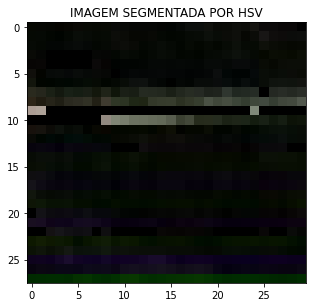

In [27]:
baixo = np.array([0, 30, 0])
alto = np.array([179, 255, 255])

imgPedunculo = [IMAGEM_CORTADA_PEDUNCULO]

for pedunculo in imgPedunculo:
    
    img = cv.imread(pedunculo)
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    mask = cv.inRange(img_hsv, baixo, alto)
    
    img_seg = cv.bitwise_and(img, img, mask = mask)
    
cv.imwrite(PEDUNCULO_HSV, img_seg)
    
mostraImagem(img_seg, "IMAGEM SEGMENTADA POR HSV")

Segunda Segmentação - BGR

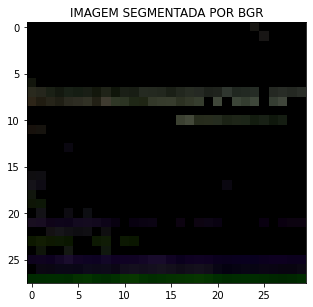

In [28]:
imgHSV = cv.imread(PEDUNCULO_HSV)

largura = imgHSV.shape[1]
altura  = imgHSV.shape[0]

imgBGR = cv.resize(imgHSV, (largura, altura))

height, width, canalCor = imgBGR.shape

base = [20,20,15]
fraca = [35,55,60]
forte = [70, 70, 100]
preto = [0, 0, 0]

for x in range(0, width):

    for y in range(0, height):

        canalXY = imgBGR[y,x]

        if all(canalXY <= base):

            imgBGR[y,x] = preto

        elif all(canalXY > fraca):

            imgBGR[y,x] = preto


cv.imwrite(PEDUNCULO_BGR, imgBGR)

mostraImagem(imgBGR, "IMAGEM SEGMENTADA POR BGR")

## Encontra ponto - trabalhar apenas com o pedúnculo

In [29]:
imgSegBGR = cv.imread(PEDUNCULO_BGR) #Leitura da imagem de entrada, imagem encontrada anteriormente - imagem cortada
gray = cv.cvtColor(imgSegBGR, cv.COLOR_BGR2GRAY) #Converte a imagem para tons de cinza

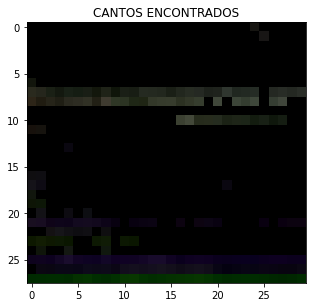

In [30]:
todas_coordenadas = [] 
todas_coordenadasX = [] #Guarda as coordenadas do eixo X vindas dos cantos encontrados
todas_coordenadasY = [] #Guarda as coordenadas do eixo Y vindas dos cantos encontrados

cornersPonto = cv.goodFeaturesToTrack(gray, 20, 0.2, 0.25) #Função responsavel por encontrar os cantos Harrys

for item in cornersPonto:
    
    x,y = item[0]
    
    todas_coordenadas.append((x,y))
    todas_coordenadasX.append(int(x))
    todas_coordenadasY.append(int(y))
    #cv.circle(imgSegBGR, (int(x),int(y)), 1, (0,0,255))
    
mostraImagem(imgSegBGR, "CANTOS ENCONTRADOS")

In [31]:
#print(todas_coordenadasX)
#print(todas_coordenadasY)
#print(todas_coordenadas)

## Função encontra ponto de partida

In [32]:
#Funções

#Calcula o peso das coordenadas

def calculaPeso(a):
    
    calPeso = (a[0] * a[0]) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = int(calPeso)
    
    return calPeso

#Faz a combinação entre a coordenadas e os pesos

def combinacao(peso: list, todas_coordenadasN: list) -> list:
    
    assert len(peso) == len(todas_coordenadasN)
 
    n = len(peso)
    
    combi = []
 
    for i in range(n):
        
        combi.append((peso[i], todas_coordenadasN[i]))
 
    return combi

#Calcula a media dos pontos

def calculaMedia(m):
    
    calMedia = (m[0] * m[1]) / 2
    
    calMedia = int(calMedia)
    
    return calMedia

In [33]:
peso = []
mediaX = []
mediaY = []

#Calcula o peso
for i in todas_coordenadas:
    
    aux = calculaPeso(i)
    
    peso.append(aux)
    
combinacaoX = combinacao(peso, todas_coordenadasX)
combinacaoY = combinacao(peso, todas_coordenadasY)

somatorioPeso = sum(peso)
mediaPeso = np.mean(peso)

#Calcula a media dos pontos X
for i in range(len(todas_coordenadasX)):
    
    #aux = calculaMedia(i)
    
    if(todas_coordenadasX[i] > mediaPeso):
        
        aux = mediaPeso
        
    else:
        
        aux = todas_coordenadasX[i]
        
    mediaX.append(aux)
    
#Calcula a media dos pontos Y
for i in combinacaoY:
    
    aux = calculaMedia(i)
    
    mediaY.append(aux)


somatorioX =  sum(mediaX)
somatorioY =  sum(mediaY)

pontoX = np.mean(mediaX)
pontoY = somatorioY / somatorioPeso

pontoX = int(pontoX)
pontoY = int(pontoY)


In [34]:
#pontoX = np.mean(todas_coordenadasX)
#pontoY = np.mean(todas_coordenadasY)
#pontoX = int(pontoX)
#pontoY = int(pontoY)

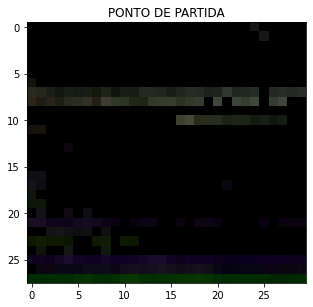

In [35]:
pontoPartida = (pontoX, pontoY)
#cv.circle(imgSegBGR, (pontoX, pontoY), 1, (0,255,0))
    
mostraImagem(imgSegBGR, "PONTO DE PARTIDA")

In [36]:
#Funcao que verifica o RGB de cada pixel

def marca_ponto(ponto_y, ponto_x):
    
    #Verifica se os valores de um determinado pixel é maior que o RGB(100, 120, 40)
    
    if np.any(imgSegBGR[int(ponto_y), int(ponto_x)] > [38, 39, 33]):
    
        return 1
    
    else:
        
        return 0

In [37]:
caminhoPontos = []
contaBuscas = 0

#Ponto maximo dos cantos encontrados 
pontoMaximoX = max(todas_coordenadasX)
pontoMaximoY = max(todas_coordenadasY)

#A busca é realizada enquanto o ponto não for encontrado, para ser considerado um ponto deve-se está com a faixa de cores válida
inicio = time.time()

while(True):
    
    ponto = marca_ponto(int(pontoY), int(pontoX))
    
    if(ponto == 1):
        
        pontoY, pontoX = pontoY, pontoX
        
        break
        
    elif(ponto == 0 and pontoX >= pontoMaximoX):
        
        pontoY, pontoX = pontoY, pontoX - 1
        
    elif(ponto == 0 and pontoY >= pontoMaximoY):
        
        pontoY, pontoX = pontoY - 1, pontoX
        
    else:
        
        pontoY, pontoX = pontoY + 1, pontoX - 1
                
    caminhoPontos.append((pontoX, pontoY))  
    
    contaBuscas = contaBuscas + 1

fim = time.time()

tempo = fim - inicio
        
pontoX = int(pontoX)
pontoY = int(pontoY)

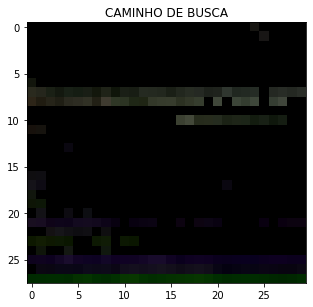

In [38]:
for item in caminhoPontos:
    
    x,y = item[0], item[1]
    
    #cv.circle(imgSegBGR, (x,y), 1, (0,0,255))

mostraImagem(imgSegBGR, "CAMINHO DE BUSCA")

## Imagem de saída com o ponto encontrado

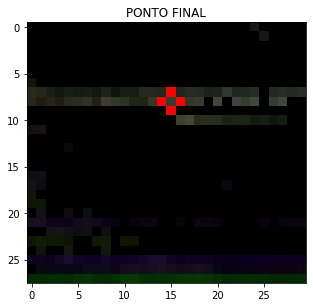

In [39]:
cv.circle(imgSegBGR, (pontoX,pontoY), 1, (255,0,0))
mostraImagem(imgSegBGR, "PONTO FINAL")

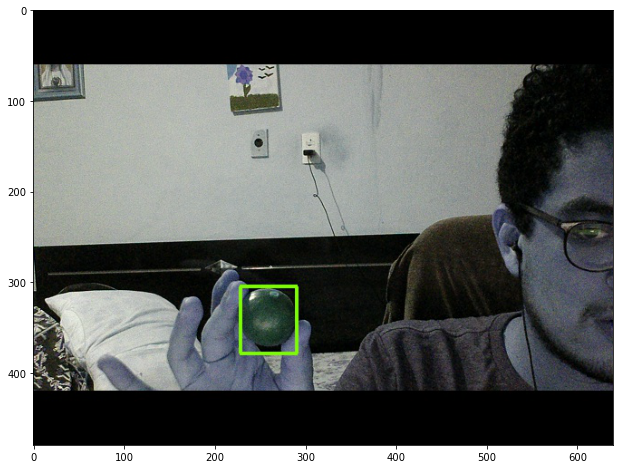

In [40]:
img = cv.imread(IMAGEM_CAPTURADA_NORMAL)

PontoFinalX = TopLeftX + pontoX
PontoFinalY = TopLeftY + pontoY

cv.circle(img, (PontoFinalX, PontoFinalY), 1, (255,255,255))

cv.imwrite("resultadoFinal/pedunculoEncontradoAritimetica" + idImagem + ".jpg", img)

fig = plt.figure(figsize = (20,8))
plt.imshow(img)
plt.show()

In [41]:
print("Coordenada de partida x,y: {}".format(pontoPartida))
print("A quantidade de busca foram: {}".format(contaBuscas))
print("O tempo de busca foi: {}".format(tempo))
print("As coordenadas pedunculo foram x,y: ({},{})".format(pontoX, pontoY))
print("As coordenadas finais são: x,y: ({},{})".format(PontoFinalX, PontoFinalY))

Coordenada de partida x,y: (11, 4)
A quantidade de busca foram: 4
O tempo de busca foi: 0.0010273456573486328
As coordenadas pedunculo foram x,y: (15,8)
As coordenadas finais são: x,y: (262,283)
